# Team:
# Antoine Abou Faycal & Mahdi Alhakim
# EECE 490
# GitHub Link: https://github.com/antoineabf/EECE490_Hackathon
# Cluster Smokers Based on Behavior and Traits Using K-Means Clustering
## 1. Introduction

Clustering analysis is an unsupervised machine learning technique used to group similar data points together based on their features. In this notebook, we will use **K-Means Clustering** to categorize smokers based on various demographic and personality traits. This segmentation can help in understanding different smoker profiles.

## 2. Import Necessary Libraries

Importing all the required libraries for data manipulation, preprocessing, clustering, visualization, and handling warnings.

In [7]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# For better visualization aesthetics
sns.set(style="whitegrid")



---

## 3. Load the Dataset

Load the dataset from an Excel file into a pandas DataFrame. Ensure that the file `'2024_PersonalityTraits_SurveyData.xls'` is located in your working directory.



In [8]:
# Load the Dataset
df = pd.read_excel('2024_PersonalityTraits_SurveyData.xls')

# Display initial shape and columns
print('Initial DataFrame shape:', df.shape)
print('Columns:', df.columns.tolist())

Initial DataFrame shape: (212, 48)
Columns: ['Unnamed: 0', 'Sector', 'Last page', 'Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?', 'I see myself as someone who is extraverted, enthusiastic:', 'I see myself as someone who is critical, quarrelsome:', 'I see myself as someone who is dependable, self-disciplined:', 'I see myself as someone who is anxious, easily upset:', 'I see myself as someone who is open to new experiences:', 'I see myself as someone who is reserved, quiet:', 'I see myself as someone who is sympathetic, warm:', 'I see myself as someone who is disorganized, careless:', 'I see myself as someone who is calm, emotionally stable:', 'I see myself as someone who is conventional, uncreative:', 'Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?', 'How many cigarettes do you smoke each day?', 'Do you smoke more frequently during the first hours after wak



---

## 4. Data Cleaning

Remove unnecessary columns from the dataset to streamline the analysis. This includes removing unnamed columns and any columns containing `'Comment'` in their names.



In [9]:
# Remove Unnecessary Columns
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Identify columns containing 'Comment'
comment_columns = [col for col in df.columns if 'Comment' in col]
df = df.drop(columns=comment_columns, errors='ignore')

# Verify columns have been removed
print("\nColumns after removal:")
print(df.columns.tolist())


Columns after removal:
['Sector', 'Last page', 'Have you smoked at least one full tobacco cigarette (excluding e-cigarettes) once or more in the past 30 days?', 'I see myself as someone who is extraverted, enthusiastic:', 'I see myself as someone who is critical, quarrelsome:', 'I see myself as someone who is dependable, self-disciplined:', 'I see myself as someone who is anxious, easily upset:', 'I see myself as someone who is open to new experiences:', 'I see myself as someone who is reserved, quiet:', 'I see myself as someone who is sympathetic, warm:', 'I see myself as someone who is disorganized, careless:', 'I see myself as someone who is calm, emotionally stable:', 'I see myself as someone who is conventional, uncreative:', 'Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?', 'How many cigarettes do you smoke each day?', 'Do you smoke more frequently during the first hours after waking up than during the rest of the



---

## 5. Handle Missing Values

Identify and handle missing values in both categorical and numerical columns. For categorical columns, fill missing values with `'Unknown'`. For numerical columns, convert them to numeric types and fill missing values with the median of the respective column.

### Define Categorical and Numerical Columns



In [10]:
# Define Categorical and Numerical Columns
categorical_columns = [
    'Gender:',
    'I see myself as someone who is extraverted, enthusiastic:',
    'I see myself as someone who is critical, quarrelsome:',
    'I see myself as someone who is dependable, self-disciplined:',
    'I see myself as someone who is anxious, easily upset:',
    'I see myself as someone who is open to new experiences:',
    'I see myself as someone who is reserved, quiet:',
    'I see myself as someone who is sympathetic, warm:',
    'I see myself as someone who is disorganized, careless:',
    'I see myself as someone who is calm, emotionally stable:',
    'I see myself as someone who is conventional, uncreative:',
    'How often do you feel stressed?',
    'Employment Status',
    'What is your favorite or preferred cigarette brand(s) if you were able to access it?',
    'What cigarette brand(s) are you currently using?'
]

numerical_columns = [
    'How old are you?',
    # 'How many cigarettes do you smoke each day?',  # Target variable
]



### Fill Missing Values



In [11]:
# Handle Missing Values for Categorical Columns
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')
    else:
        print(f"Warning: Categorical column '{col}' not found in DataFrame.")

# Handle Missing Values for Numerical Columns
for col in numerical_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())
    else:
        print(f"Warning: Numerical column '{col}' not found in DataFrame.")



### Verify No Missing Values Remain



In [12]:
# Verify No Missing Values Remain
print('\nMissing values after imputation:')
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values after imputation:
Series([], dtype: int64)



---

## 6. Encode Categorical Variables

Convert categorical variables into numerical formats suitable for clustering. A predefined `response_mapping` is used to map textual responses to numerical values.

### Define Response Mapping



In [13]:
# Encode Categorical Input Features
response_mapping = {
    'Disagree strongly': 1,
    'Disagree a little': 2,
    'Agree a little': 3,
    'Agree moderately': 4,
    'Agree strongly': 5,
    'Unknown': 0  # For any unspecified or missing responses
}



### Apply Mapping to Categorical Columns



In [15]:
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].map(response_mapping)
        df[col] = df[col].fillna(0).astype(int)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")



### Encode the Target Variable

The target variable `'How many cigarettes do you smoke each day?'` is optional for clustering since clustering is unsupervised. If present, we can encode it for potential supervised analyses.



In [16]:
# Encode the Target Variable (if needed)
target_column = 'How many cigarettes do you smoke each day?'
if target_column in df.columns:
    le_target = LabelEncoder()
    df[target_column] = le_target.fit_transform(df[target_column].astype(str))
    print(f"\nClasses for '{target_column}': {list(le_target.classes_)}")
else:
    print(f"Error: Target column '{target_column}' not found in DataFrame.")


Classes for 'How many cigarettes do you smoke each day?': ['10 or less cigarettes/day', '11 to 20 cigarettes', '21 to 30 cigarettes', '31 cigarettes/day or more']





---

<a id='FeatureSelection'></a>
## 7. Feature Selection

Select relevant features for the clustering model. Typically, we exclude the target variable and any identifier columns.



In [17]:
# Select Features (excluding target)
features = [
    'How old are you?',
    'Gender:',
    'I see myself as someone who is extraverted, enthusiastic:',
    'I see myself as someone who is critical, quarrelsome:',
    'I see myself as someone who is dependable, self-disciplined:',
    'I see myself as someone who is anxious, easily upset:',
    'I see myself as someone who is open to new experiences:',
    'I see myself as someone who is reserved, quiet:',
    'I see myself as someone who is sympathetic, warm:',
    'I see myself as someone who is disorganized, careless:',
    'I see myself as someone who is calm, emotionally stable:',
    'I see myself as someone who is conventional, uncreative:',
    'How often do you feel stressed?',
    'Employment Status',
    'What is your favorite or preferred cigarette brand(s) if you were able to access it?',
    'What cigarette brand(s) are you currently using?'
]

# Check for missing feature columns
missing_features = [col for col in features if col not in df.columns]
if missing_features:
    print('\nMissing feature columns:', missing_features)
else:
    print('\nAll feature columns found.')


All feature columns found.




### Assign Feature Set and Target



In [18]:
if target_column in df.columns:
    X = df[features]
    y = df[target_column].astype(int)
else:
    X = df[features]
    y = None

print('Features shape:', X.shape)
if y is not None:
    print('Target shape:', y.shape)

Features shape: (212, 16)
Target shape: (212,)




---

## 8. Feature Scaling

Standardize the feature set to ensure that all features contribute equally to the clustering process.



In [19]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



---

## 9. Apply K-Means Clustering

Perform K-Means clustering with a specified number of clusters (3 in this case). Assign descriptive labels to each cluster.



In [20]:
# Apply K-Means Clustering with 3 Clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = clusters

# Map cluster numbers to labels
cluster_mapping = {0: 'Low', 1: 'Medium', 2: 'Extreme'}
df['Cluster'] = df['Cluster'].map(cluster_mapping)



---


## 10. Visualize Clusters with PCA

Use Principal Component Analysis (PCA) to reduce the dimensionality of the data for visualization purposes. Plot the clusters in the PCA-reduced 2D space.



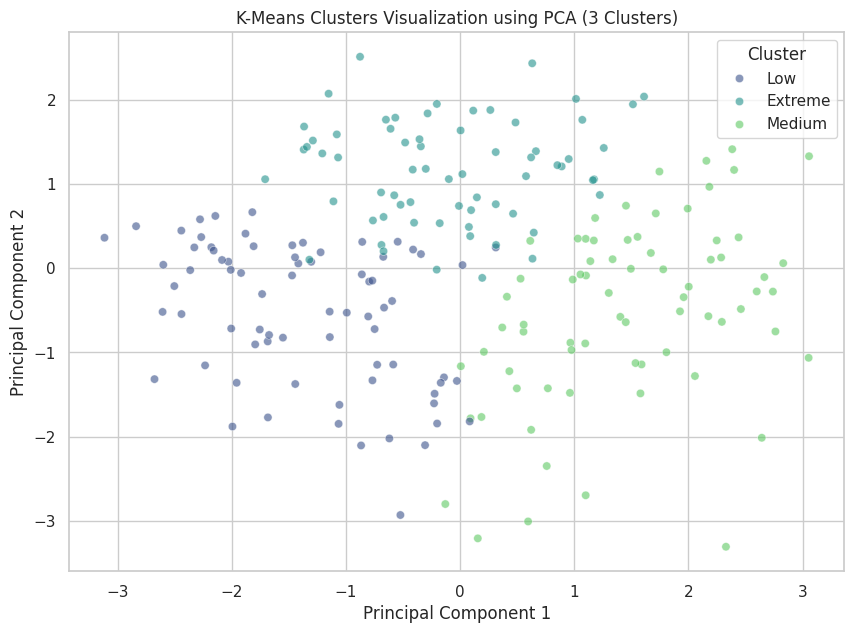

In [21]:
# Visualize Clusters using PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)
df['PC1'] = principal_components[:,0]
df['PC2'] = principal_components[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df, palette='viridis', alpha=0.6)
plt.title('K-Means Clusters Visualization using PCA (3 Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()





---

<a id='Analysis'></a>
## 11. Analyze Cluster Characteristics

Examine the average values of each feature within each cluster to understand the defining traits of each group.



In [22]:
# Analyze Cluster Characteristics
cluster_summary = df.groupby('Cluster')[features].mean().reset_index()
print('\nCluster Characteristics:')
print(cluster_summary)


Cluster Characteristics:
   Cluster  How old are you?  Gender:  \
0  Extreme         21.303030      0.0   
1      Low         24.175676      0.0   
2   Medium         22.013889      0.0   

   I see myself as someone who is extraverted, enthusiastic:  \
0                                           3.969697           
1                                           3.554054           
2                                           1.819444           

   I see myself as someone who is critical, quarrelsome:  \
0                                           2.606061       
1                                           1.148649       
2                                           2.416667       

   I see myself as someone who is dependable, self-disciplined:  \
0                                           3.454545              
1                                           4.189189              
2                                           2.930556              

   I see myself as someone who is anxious,




---

<a id='Conclusion'></a>
## 12. Conclusion

In this notebook, we successfully performed K-Means clustering on a dataset of smokers' behaviors and traits. The key steps included:

- **Data Loading and Cleaning:** Imported the dataset, removed unnecessary columns, and handled missing values.
- **Feature Encoding:** Transformed categorical variables into numerical formats suitable for modeling.
- **Clustering:** Applied K-Means clustering to segment the data into distinct groups.
- **Visualization:** Used PCA to visualize the clusters in a 2D space.
- **Analysis:** Analyzed the characteristics of each cluster to understand the defining features.